# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier

# Directories

In [2]:
track = 'Long'
particle = 'Electron'

data_path = "data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/XGBoost"

netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [40]:
data = pandas.read_csv(data_path + "/data_train.csv")

# Features

In [4]:
def get_features(netconfig_path):
    
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

In [5]:
features_all = []

for one_particle in particles:
    
    netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
    + one_particle + "_Long_ANN.txt"

    features_all += get_features(netconfig_path)

In [6]:
features = numpy.unique(features_all)
features

array(['BremPIDe', 'CaloPrsE', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe',
       'HcalPIDmu', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon',
       'InAccPrs', 'MuonBkgLL', 'MuonIsLooseMuon', 'MuonIsMuon',
       'MuonMuLL', 'MuonNShared', 'PrsPIDe', 'RichAboveKaThres',
       'RichAboveMuThres', 'RichAbovePiThres', 'RichAbovePrThres',
       'RichDLLbt', 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp',
       'RichUsedR1Gas', 'RichUsedR2Gas', 'TrackChi2PerDof',
       'TrackFitMatchChi2', 'TrackFitTChi2', 'TrackFitTNDoF',
       'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackGhostProbability',
       'TrackNumDof', 'TrackP', 'TrackPt'], 
      dtype='|S21')

# Train XGBoost

In [42]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [43]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.01 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.01549947,  0.07053886,  0.08679237,  0.14642896,  0.40215825,
        2.13903743])

In [44]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [31]:
%%time
clf = XGBoostClassifier(n_estimators=1000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=4, 
                        subsample=0.5, 
                        max_depth=8,
                        min_child_weight = 100,
                        features=features)

clf.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)

CPU times: user 15h 45min 42s, sys: 28.7 s, total: 15h 46min 11s
Wall time: 4h 21min 43s


# Save the classifier

In [32]:
params = clf.get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [33]:
new_work_path = work_path + "/" + params_str
new_work_path

'baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=100;colsample=0.7;max_depth=8;gamma=None;nthreads=4;'

In [34]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

# clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
# pickle.dump(clf, clf_pickle)
# clf_pickle.close()

In [46]:
new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/\
multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;\
base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=100;colsample=0.7;max_depth=8;\
gamma=None;nthreads=4;"

In [48]:
# Read classifier
clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
clf2 = pickle.load(clf_pickle2)
clf_pickle2.close()

# Test the classifier

In [50]:
probas = clf2.predict_proba(data.loc[test_inds])

In [51]:
probas[:5, :]

array([[  2.62566842e-02,   4.47872007e-04,   2.60399329e-03,
          9.67501879e-01,   1.68709003e-03,   1.50248350e-03],
       [  1.12255448e-02,   1.26310950e-03,   3.27402051e-03,
          5.59824519e-02,   5.03178120e-01,   4.25076783e-01],
       [  1.55307893e-02,   2.91220873e-04,   1.88203680e-03,
          9.80515599e-01,   1.00090436e-03,   7.79409951e-04],
       [  6.60598427e-02,   8.00022364e-01,   2.03780960e-02,
          7.42517039e-02,   2.40580644e-02,   1.52299656e-02],
       [  3.98175120e-01,   2.89928704e-03,   5.89793809e-02,
          5.29470563e-01,   5.28867496e-03,   5.18696615e-03]], dtype=float32)

### Logloss

In [53]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

0.65804831582395262

### Roc curves

In [37]:
#particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
colors = ['k', 'r', 'g', 'b', 'gold', 'm']

def get_roc_curves(probas, labels, particles, colors, labs):

    plt.figure(figsize=(10,7))

    for num in range(0, len(particles)):
        
        one_particle = particles[num]
        one_color = colors[num]
        one_lab = labs[num]

        one_labels = (labels == one_lab)*1
        one_probas = probas[:, num]
        roc_auc = roc_auc_score(one_labels, one_probas)
        fpr, tpr, _ = roc_curve(one_labels, one_probas)
        plt.plot(fpr, tpr, label=one_particle + ', %.2f' % roc_auc, color=one_color, linewidth=2)

    plt.title("ROC AUC", size=15)
    plt.xlabel("FPR", size=15)
    plt.ylabel("TPR", size=15)
    plt.legend(loc='best',prop={'size':15})
    plt.xticks(numpy.arange(0, 1.01, 0.1), size=15)
    plt.yticks(numpy.arange(0, 1.01, 0.1), size=15)
    plt.show()

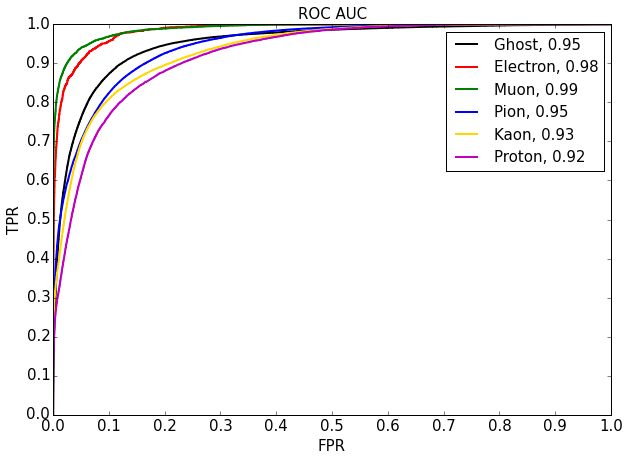

In [38]:
get_roc_curves(probas, labels_test, particles, colors, labs)

# Evaluation

In [12]:
import os, sys
sys.path.append('../python')
import utils

In [5]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [6]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [18]:
proba_eval = clf2.predict_proba(data_eval)

In [19]:
#numpy.savetxt(new_work_path + '/xgboost_proba_eval.csv', proba_eval)

In [9]:
#proba_eval = numpy.loadtxt(new_work_path + '/xgboost_proba_eval.csv')

In [10]:
proba_eval[:5, :]

array([[ 0.0100605 ,  0.00313075,  0.05235706,  0.01826009,  0.23857312,
         0.67761844],
       [ 0.00801537,  0.00174789,  0.03596535,  0.00196808,  0.64037007,
         0.31193325],
       [ 0.02568666,  0.0028671 ,  0.17325759,  0.77074051,  0.01937863,
         0.0080695 ],
       [ 0.13352223,  0.05289718,  0.47906843,  0.25751242,  0.05151432,
         0.02548537],
       [ 0.01306124,  0.00362979,  0.18676858,  0.79121512,  0.00282322,
         0.00250206]])

### Get all figures from baseline

In [17]:
import os, sys
sys.path.append('src')

from get_figures import all_figures

In [22]:
for num in range(0, len(particles)):
        
    one_particle = particles[num]
    one_lab = labs[num]

    one_labels = (labels_eval == one_lab)*1
    one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
    params = {}
    params['PARTICLE'] = one_particle
    params['TRACK'] = 'Long'
    
    all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")

### Logloss

In [31]:
from sklearn.metrics import log_loss

log_loss(labels_eval, proba_eval)

1.010150571198607

### Roc curves, roc auc matrix and roc auc ratio matrix

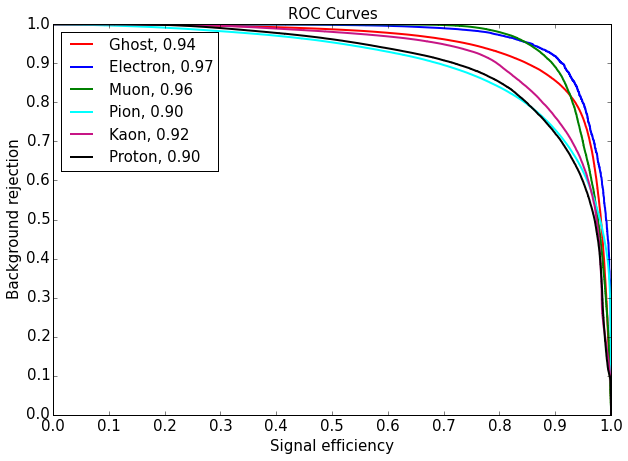

In [32]:
utils.get_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

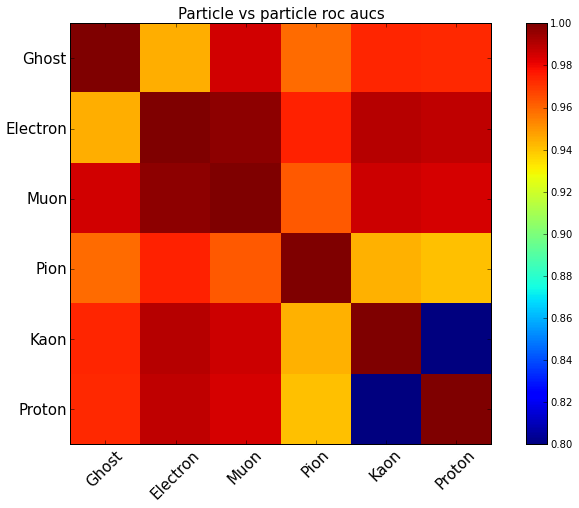

,Class,Ghost,Electron,Muon,Pion,Kaon,Proton
0,Ghost,1.000000,0.944886,0.985166,0.958961,0.974021,0.973291
1,Electron,0.944886,1.000000,0.997043,0.974551,0.990345,0.988757
2,Muon,0.985166,0.997043,1.000000,0.963008,0.986328,0.984613
3,Pion,0.958961,0.974551,0.963008,1.000000,0.944136,0.940935
4,Kaon,0.974021,0.990345,0.986328,0.944136,1.000000,0.763175
5,Proton,0.973291,0.988757,0.984613,0.940935,0.763175,1.000000


In [33]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)
roc_auc_matrix

In [34]:
roc_auc_matrix_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv")

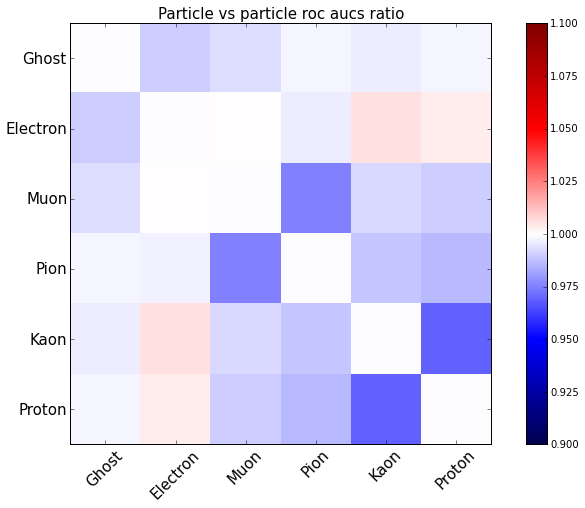

,Class,Ghost,Electron,Muon,Pion,Kaon,Proton
0,Ghost,1.000000,0.990497,0.992996,0.997802,0.996222,0.997723
1,Electron,0.990497,1.000000,1.000657,0.997034,1.005544,1.003458
2,Muon,0.992996,1.000654,1.000000,0.975126,0.992903,0.990086
3,Pion,0.997802,0.996707,0.975101,1.000000,0.988690,0.986140
4,Kaon,0.996222,1.005577,0.992903,0.988690,1.000000,0.969518
5,Proton,0.997723,1.003453,0.990086,0.986139,0.969518,1.000000


In [35]:
utils.get_roc_auc_ration_matrix(roc_auc_matrix, roc_auc_matrix_baseline, save_path=new_work_path, show=True)

### Flatness

In [36]:
%%time
flatness = utils.get_flatness_table(data_eval, labels_eval, proba_eval, particles, save_path=new_work_path)
flatness

CPU times: user 8min 7s, sys: 4.86 s, total: 8min 12s
Wall time: 8min 19s


In [37]:
flatness_baseline = pandas.read_csv("../python/flatness_baseline.csv")
flatness_baseline

,Unnamed: 0,Class,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
0,0,Electron,0.006546,0.016579,0.001014,0.001004
1,1,Proton,0.034632,0.044571,0.000886,0.000888
2,2,Pion,0.016512,0.013729,0.000853,0.000851
3,3,Muon,0.020388,0.044991,0.000905,0.000906
4,4,Kaon,0.043074,0.036657,0.000872,0.000880
5,5,Ghost,0.006591,0.014187,0.000871,0.000870


In [38]:
utils.get_flatness_ratio(f, flatness_baseline, save_path=new_work_path)

,Class,TrackP,TrackPt
0,Ghost,1.615329,2.286396
1,Electron,2.650650,1.878510
2,Muon,1.599140,0.995646
3,Pion,1.513967,1.120948
4,Kaon,0.868221,0.924070
5,Proton,0.992794,0.857867


### Efficiency curves

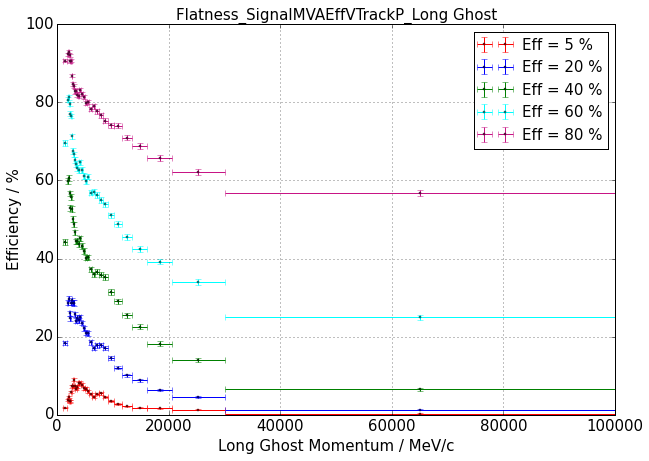

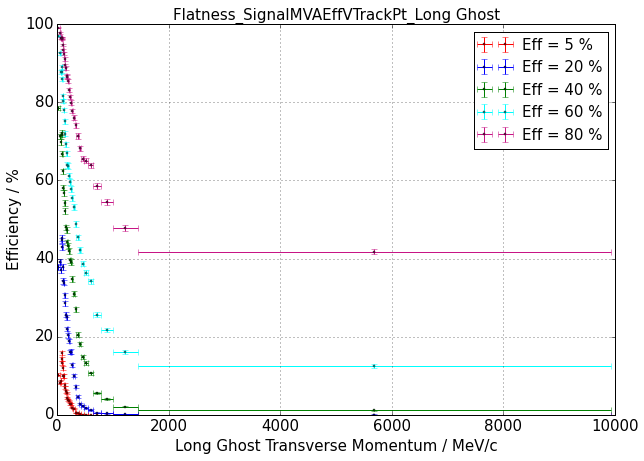

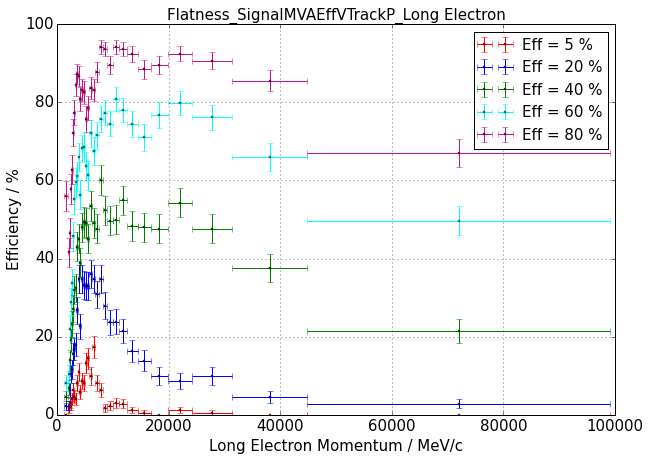

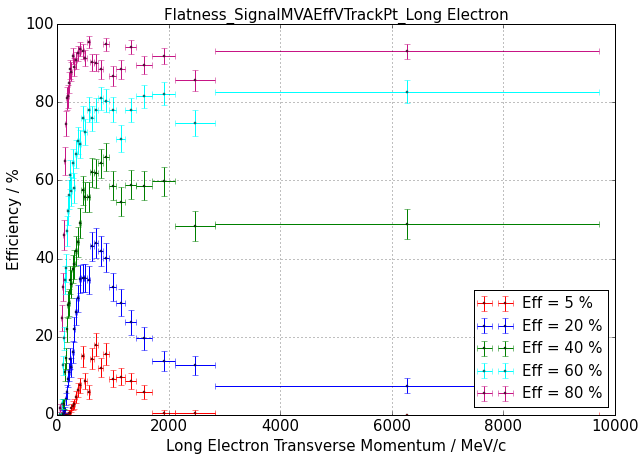

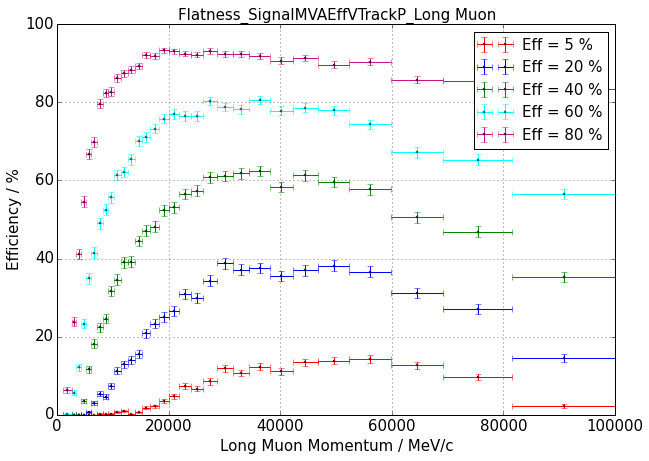

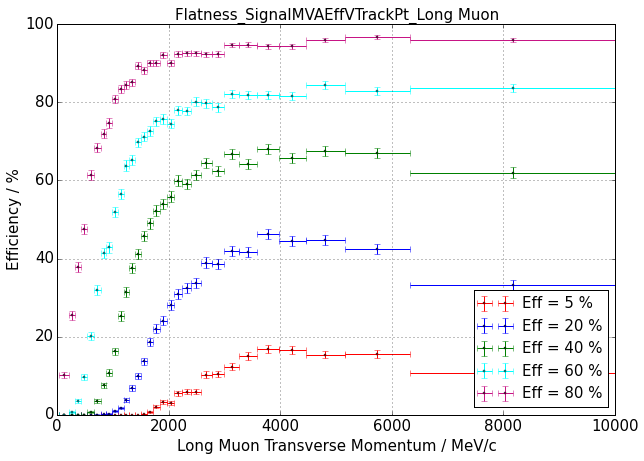

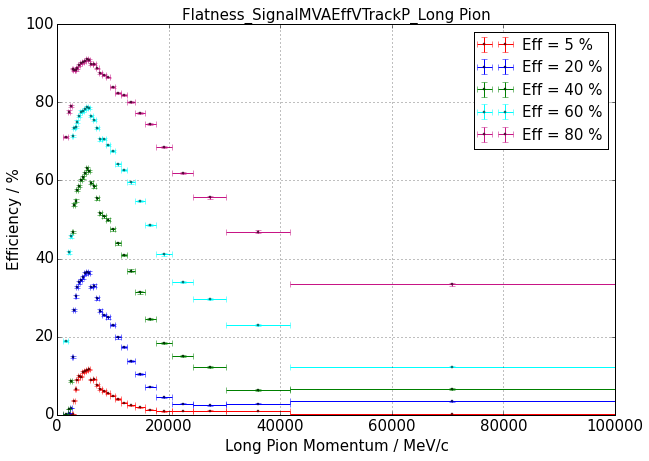

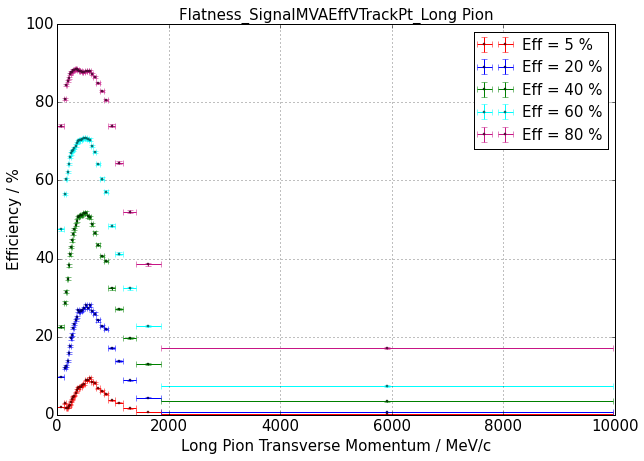

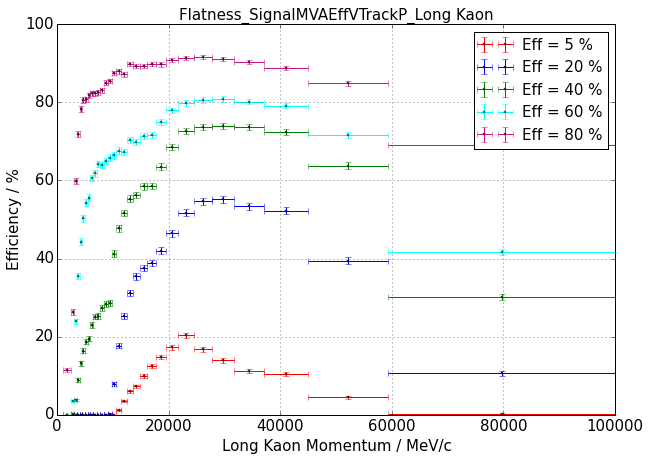

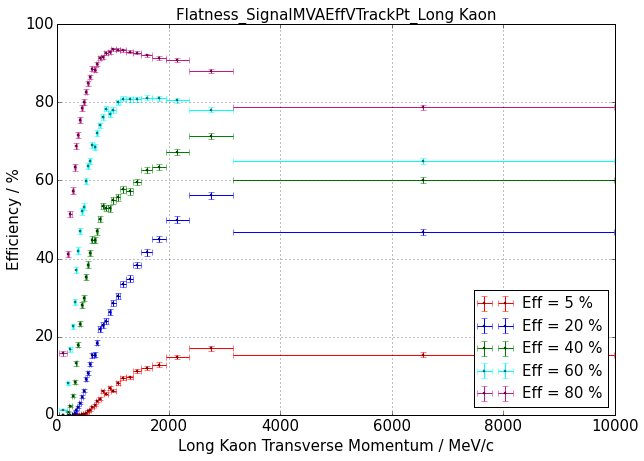

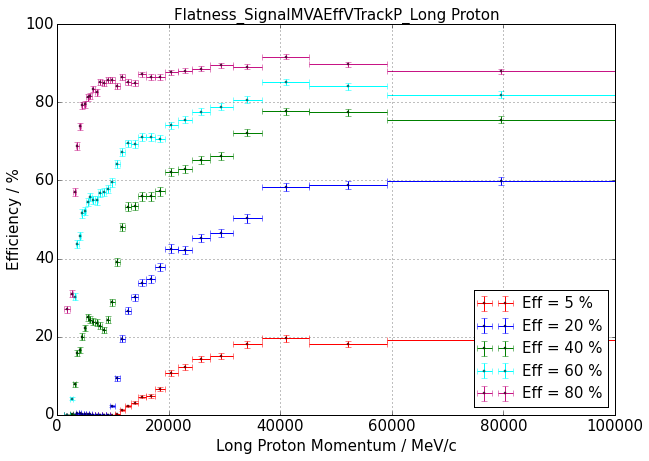

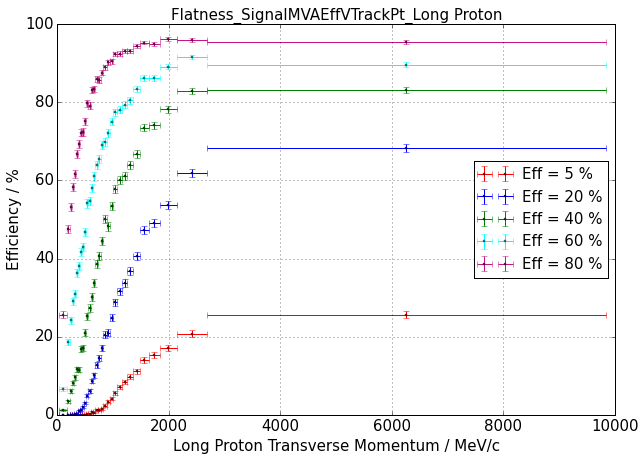

In [39]:
utils.get_all_flatness_figures(data_eval, proba_eval, labels_eval, 'Long', particles, save_path=new_work_path, show=True)